### Notebook Explanation 

This jupyter notebook allows for the visualization of Krusenstern Lagoon with the  ```krusenstern.geojson``` file. Various variables can be altered to track bloom percentage. Based on values derived from field samples when compared to satellite imagery the following classes can be defined (NDCI): 

__None__: < -0.0553

__Low__: -0.0552 - 0.0727

__Medium__: 0.0727 - 0.1874

__High__: > 0.1874

### **Library Imports**

In [2]:
import ee                                                   # Pull Google Earth Engine Images 
import geemap                                               # Map and display features 
import json                                                 # Convert json files into python dicts
import pandas as pd                                         # For csv files
import geopandas as gpd                                     # Creating gdf using geometry 
from datetime import datetime                               # For GEE dates 
import matplotlib.pyplot as plt                             # Used for NDCI index bar
from matplotlib.colors import LinearSegmentedColormap       # Used for NDCI index bar

### **Server Authentication**

In [3]:
# Authenticate GEE server
ee.Authenticate()
ee.Initialize()

### **Bands, Resolution, Utility**
- Sentinel Bands Used: B3 (green, 10m), B4 (red, 10m), B5 (red edge, 20m), B8 (NIR, 10m)
- Sentinel-2 has a 5 day revisit time (best satellite to optimize temporal resolution)
- Script calculates the percentage of a lagoon covered by a harmful bloom (depends on variable)
- Below find the calculations for relevant indices: 

**Normalized Difference Chlorophyll Index Calculation:**
$$NDCI = \frac{B5 - B4}{B5 + B4}$$

**Normalized Difference Chlorophyll Index Calculation (Wavelength):**
$$NDCI = \frac{705nm - 665nm}{705nm + 665nm}$$

**Normalized Difference Water Index Calculation:**
$$NDWI = \frac{B3 - B8}{B3 + B8}$$

**Normalized Difference Water Index Calculation:**
$$NDWI = \frac{560nm - 842nm}{560nm + 842nm}$$

<sup>*nm indicating nanometers</sup>

### GeoDataFrame creation and ensure geometry is functional 
- Create the gdf to load data 
- Project to the WGS 84 (proper projection for GEE)
- Convert gdf to GeoJson so it can be read by GEE
- Create an Earth Engine feature collection from the parsed GeoJson file

In [4]:
# Create GeoDataFrame for lagoon polygons
gdf = gpd.read_file("Data/krusenstern.geojson")

# Exported as Alaska Albers, need to be WGS 84 for Earth Engine
gdf = gdf.to_crs("EPSG:4326")           
geojson_str = gdf.to_json()
lagoon_fc = ee.FeatureCollection(json.loads(geojson_str))

# IMPORTANT! 
# Check geometry to ensure files loaded properly 
# Include .head(3) for large dataset 
print( "GeoDataFrame: \n ", gdf['geometry'].head(3))            

GeoDataFrame: 
  0    POLYGON ((-163.53176 67.15001, -163.53286 67.1...
Name: geometry, dtype: geometry


### Preform Calculations and Apply Indices 
- Define functions for calculating NDCI and NDWI
- Have user select lagoon and date range 
- Generate relevant data (calculate percentage of algal bloom)
- Display map with selected polygon 

Available lagoons for selection: ['Krusenstern']
Number of cloud-free images found: 1
Available dates for selection: ['2024-06-21']

Algal Bloom Coverage (percentage): 
 2024-06-21: Percent Bloom Coverage = 0.06% 


Map(center=[67.14886918149696, -163.63464751527445], controls=(WidgetControl(options=['position', 'transparent…

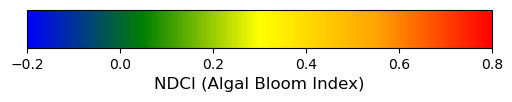

In [6]:
# Function to calculate Normalized Difference Chlorophyll Index
def calculate_ndci(image):
    '''
    Calculate the Normalized Difference Chlorophyll Index (NDCI)
    Band Math/Algebra: (B5 - B4) / (B5 + B4)
    '''
    ndci = image.normalizedDifference(['B5','B4']).rename('NDCI')
    return image.addBands(ndci)

# Function to calculate the Normalized Difference Water Index
def mask_land(image):
    '''
    Calculate the Normalized Difference Water Index (NDWI)
    A mask is applied for pixels where NDWI > 0.1 (likely water)
    Band Math/Algebra: (B3 - B8) / (B3 + B8)
    '''
    ndwi = image.normalizedDifference(['B3','B8']).rename('NWDI')
    water_mask = ndwi.gt(0.1)
    return image.updateMask(water_mask)

# Convert lagoon names to list
lagoon_names = gdf['LagoonFeature'].tolist()
print('Available lagoons for selection:', lagoon_names)

# Ask user for lagoon name
lagoon_name = input('Enter an available lagoon: ')

# Filter lagoon features
selected_feature = lagoon_fc.filter(ee.Filter.eq('LagoonFeature', lagoon_name))
if selected_feature.size().getInfo() == 0:
    print('Feature Class not Found. Please check your input')
    exit()

roi = selected_feature.geometry()

# Ask user to select a date range
start_date_str = input('Enter start date (YYYY-MM-DD): ')
end_date_str = input('Enter end date (YYYY-MM-DD): ')

# Handle invalid date formats
try:
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
except ValueError:
    print('Invalid date format. Please enter dates in YYYY-MM-DD format.')
    exit()

# Load the Sentinel-2 Harmonized collection
sentinel_collection = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(roi)
    .filterDate(start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))
    .map(calculate_ndci)
    .map(mask_land)
    .map(lambda img: img.clip(roi))
)

image_count = sentinel_collection.size().getInfo()
print(f'Number of cloud-free images found: {image_count}')

dates_of_interest = []

# >>============== Set Threshold Values ==============<<

ndci_threshold = 0.2       # Flags dates where the mean value is above the 'threshold' (e.x. 0.2) as a bloom event 
algae_threshold = 0.2      # Value that determines if a pixel is counted as 'algal bloom'

if image_count > 0:
    image_list = sentinel_collection.toList(image_count)
    dates = [ee.Image(image_list.get(i)).date().format('yyyy-MM-dd').getInfo() for i in range(image_count)]
    print("Available dates for selection:", dates)

    for i in range(image_count):
        img = ee.Image(image_list.get(i))
        ndci_img = img.select('NDCI')
        date = img.date().format('yyyy-MM-dd').getInfo()

        # Mean NDCI 
        mean_stats = ndci_img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi,
            scale=20,
            maxPixels=1e9
        )
        mean_val = mean_stats.get('NDCI').getInfo()

        # Max NDCI
        max_stats = ndci_img.reduceRegion(
            reducer=ee.Reducer.max(),
            geometry=roi,
            scale=20,
            maxPixels=1e9
        )
        max_val = max_stats.get('NDCI').getInfo()

        # Min NDCI
        min_stats = ndci_img.reduceRegion(
            reducer=ee.Reducer.min(),
            geometry=roi,
            scale=20,
            maxPixels=1e9
        )
        min_val = min_stats.get('NDCI').getInfo()

        # Algae mask and pixel count  
        algae_mask = ndci_img.gt(algae_threshold)
        algae_pixel_count = algae_mask.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=roi,
            scale=20,
            maxPixels=1e9
        ).get('NDCI').getInfo()

        valid_pixel_count = ndci_img.mask().reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=roi,
            scale=20,
            maxPixels=1e9
        ).get('NDCI').getInfo()

        if valid_pixel_count and algae_pixel_count is not None:
            percent_algae = algae_pixel_count / valid_pixel_count * 100
        else:
            percent_algae = None

        # Store stats
        if mean_val is not None:
            dates_of_interest.append({
                'date': date,
                'mean': round(mean_val, 3),
                'max': round(max_val, 3) if max_val is not None else None,
                'min': round(min_val, 3) if min_val is not None else None,
                'algae_pct': round(percent_algae, 2) if percent_algae is not None else None
            })

    # Print summary
    print("\nAlgal Bloom Coverage (percentage): ")
    for entry in dates_of_interest:
        line = (
            # f" {entry['date']}: Bloom Coverage = {entry['algae_pct'] if entry['algae_pct'] is not None else 'N/A'}"
            f" {entry['date']}: Percent Bloom Coverage = {entry['algae_pct']}% " if entry['algae_pct'] is not None else f"{entry['date']}: Bloom Coverage = N/A"
        )
        if entry['mean'] > ndci_threshold:
            line += ""
        print(line)

    # User selects date and visualizes
    while True:
        selected_date = input("Enter the date you want to view (or type 'Stop' to exit): ")
        if selected_date.lower() == 'stop':
            break

        if selected_date in dates:
            index = dates.index(selected_date)
            selected_image = ee.Image(image_list.get(index)).clip(roi)

            Map = geemap.Map()
            Map.centerObject(roi, 10)
            Map.add_basemap("Esri.WorldImagery")
            # Map.add_basemap('Esri.WorldTopoMap')                         >> Optional map, WorldImagery is better 

            rgb_vis = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000, 'gamma': 1.4}
            ndci_vis = {
                'bands': ['NDCI'],
                'min': 0, 'max': 0.5,
                'palette': ['blue', 'green', 'yellow', 'orange', 'red']
            }
            algae_vis = {
                'bands': ['NDCI'],
                'min': algae_threshold,
                'max': 0.5,
                'palette': ['yellow', 'orange', 'red']
            }

            Map.addLayer(selected_image, rgb_vis, 
                         f"RGB - {lagoon_name} - {selected_date}")
            Map.addLayer(selected_image.select('NDCI'), 
                         ndci_vis, 'NDCI (Algal Bloom Index)')
            Map.addLayer(selected_image.select('NDCI').updateMask(selected_image.select('NDCI').gt(algae_threshold)),
                         algae_vis, 'Algae Detected')
            Map.addLayer(selected_feature.style(color='black', 
                                                fillColor='00000000'), {}, 'Lagoon Boundary')

            # Optional legend for NDCI
            def display_ndci_legend():
                ndci_min, ndci_max = -0.2, 0.8
                colors = ['blue', 'green', 'yellow', 'orange', 'red']
                cmap = LinearSegmentedColormap.from_list("custom_ndci", colors, N=256)
                norm = plt.Normalize(vmin=ndci_min, vmax=ndci_max)
                fig, ax = plt.subplots(figsize=(6, 1))
                fig.subplots_adjust(bottom=0.5)
                cb = plt.colorbar(
                    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
                    cax=ax,
                    orientation='horizontal'
                )
                cb.set_label("NDCI (Algal Bloom Index)", fontsize=12)
                plt.show()

            display(Map)
            display_ndci_legend()
        else:
            print("Date not found. Please choose from available options.")
else:
    print("No valid images found for this lagoon and date range.")
